## Forecasting Water Demand

In [31]:
import pickle
import warnings
from math import sqrt

import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import pmdarima as pm
import tensorflow as tf
import xgboost as xgb
from xgboost import XGBRegressor as xgbr

from gluonts.mx.trainer import Trainer
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, Normalizer, PowerTransformer, QuantileTransformer, RobustScaler
from tqdm import tqdm

from utils.metrics import evaluate

# We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones
warnings.filterwarnings("ignore")


# Extra settings
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
mpl.rcParams['figure.figsize'] = 18, 8

print(tf.__version__)

2.13.0


### 1. Prepare data before Forecasting

In [32]:
# set city name
city_data = "1_goyang_city.xlsx"
city_name = "GoYang-City"

In [33]:
# Read excel file using pandas
df = pd.read_excel(open(f"./data/{city_data}", 'rb'), sheet_name="training", header=4, index_col=0)
# Remove unnecessary columns for this analysis
water_demand = df.iloc[2:]
# Change Date Format and Set Date as index
water_demand.index = pd.to_datetime(water_demand.index.str.strip(), format='%Y-%m')
water_demand.index.name = "date"
# Change data format from "Object" to "Float"
water_demand["water_supply"] = water_demand.water_supply.astype(float)
water_demand["Total_Population"] = water_demand.Total_Population.astype(float)
# Delete unnecessary columns 
water_demand.drop(columns=water_demand.columns[19:21], inplace=True)
water_demand.drop(columns=water_demand.columns[22:23], inplace=True)
# Select clean data
water_demand = water_demand.loc["2010-01-01":]
water_demand

,water_supply,Total_Population,Households,Population_per_Households,Male_Population,Female_Population,Male_Female_Ratio,Population_aging_Ratio,Power_usage,Num_of_Business,...,personal_expense,benefits_vs_personal_expense,employment_ratio,employment_insurance_ratio,Average_Temp,Monthly_Rainfall,Average_Relative_Humadity,Ground_Temp,Average_Wind,Average_Pressure
date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,282265.709677,939497.0,353741.0,2.655889,463878.0,475619.0,0.975314,0.088,434436000.0,20326.0,...,104371555.0,0.191,99001.0,0.105377,-4.5,29.3,0.65,-1.2,2.3,1013.6
2010-02-01,273685.892857,940639.0,354266.0,2.655177,464518.0,476121.0,0.975630,0.088,418156000.0,20685.0,...,104371555.0,0.191,99893.0,0.106197,1.4,55.3,0.59,1.4,2.4,1010.7
2010-03-01,269918.193548,940982.0,354003.0,2.658119,464740.0,476242.0,0.975848,0.088,346653000.0,20809.0,...,104371555.0,0.191,99678.0,0.105930,4.3,82.5,0.59,5.0,2.9,1009.6
2010-04-01,274462.700000,941737.0,354192.0,2.658832,465148.0,476589.0,0.975994,0.088,356701000.0,21857.0,...,104371555.0,0.191,101594.0,0.107879,9.5,62.8,0.54,10.8,2.9,1007.4
2010-05-01,288537.806452,941724.0,354157.0,2.659058,465110.0,476614.0,0.975863,0.089,313793000.0,21739.0,...,104371555.0,0.191,102073.0,0.108390,17.2,124.0,0.62,18.7,2.6,1000.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-01,354382.451613,1080896.0,454793.0,2.376677,528972.0,551924.0,0.958415,0.140,487867544.0,46416.0,...,218316665.0,0.293,171845.0,0.158984,25.9,211.2,0.74,28.2,2.1,998.6
2021-09-01,343537.800000,1080787.0,455501.0,2.372743,528911.0,551876.0,0.958387,0.141,401433572.0,45514.0,...,218316665.0,0.293,172771.0,0.159857,22.6,131.0,0.71,24.6,2.3,1003.4
2021-10-01,340126.806452,1080240.0,455845.0,2.369753,528683.0,551557.0,0.958528,0.142,358286760.0,45839.0,...,218316665.0,0.293,173486.0,0.160599,15.6,57.0,0.70,16.7,2.1,1011.0


In [34]:
# We split our dataset to be able to evaluate our models
resultsDict = {}
predictionsDict = {}

#air_pollution = pd.read_csv('datasets/air_pollution.csv', parse_dates=['date'])
#air_pollution.set_index('date', inplace=True)

split_date = '2018-12-01'
df_training = water_demand.loc[water_demand.index <= split_date]
df_test = water_demand.loc[water_demand.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

df_training.to_csv(f'datasets/training_{city_name}.csv')
df_test.to_csv(f'datasets/test_{city_name}.csv')

108 days of training data 
 36 days of testing data 


In [35]:
# ADD time features to our model
def create_time_features(df, target=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    X = df.drop(['date'], axis=1)
    if target:
        y = df[target]
        X = X.drop([target], axis=1)
        return X, y

    return X

In [36]:
X_train_df, y_train = create_time_features(
    df_training, target='water_supply')
X_test_df, y_test = create_time_features(df_test, target='water_supply')
scaler = StandardScaler()
scaler.fit(X_train_df)  # No cheating, never scale on the training+test!
X_train = scaler.transform(X_train_df)
X_test = scaler.transform(X_test_df)

X_train_df = pd.DataFrame(X_train, columns=X_train_df.columns)
X_test_df = pd.DataFrame(X_test, columns=X_test_df.columns)

In [37]:
X_train_df

,Total_Population,Households,Population_per_Households,Male_Population,Female_Population,Male_Female_Ratio,Population_aging_Ratio,Power_usage,Num_of_Business,Business_above_100,...,employment_insurance_ratio,Average_Temp,Monthly_Rainfall,Average_Relative_Humadity,Ground_Temp,Average_Wind,Average_Pressure,quarter,month,year
0,-1.595109,-1.404371,0.880289,-1.624560,-1.569443,1.137270,-1.516280,1.357380,-1.748463,-0.047124,...,-1.700764,-1.655629,-0.493986,0.668527,-1.406849,-0.410154,1.169269,-1.341641,-1.593255,-1.549193
1,-1.563649,-1.377685,0.864000,-1.586454,-1.543711,1.210150,-1.516280,1.006207,-1.687350,-0.047124,...,-1.636965,-1.091113,-0.341195,-0.077093,-1.175234,-0.182992,0.719484,-1.341641,-1.303572,-1.549193
2,-1.554200,-1.391053,0.931268,-1.573235,-1.537509,1.260511,-1.516280,-0.536175,-1.666241,-0.199807,...,-1.657745,-0.813640,-0.181352,-0.077093,-0.854535,0.952819,0.548876,-1.341641,-1.013890,-1.549193
3,-1.533401,-1.381446,0.947579,-1.548943,-1.519722,1.294099,-1.516280,-0.319431,-1.487838,0.410923,...,-1.506122,-0.316100,-0.297120,-0.698444,-0.337855,0.952819,0.207659,-0.447214,-0.724207,-1.549193
4,-1.533759,-1.383225,0.952748,-1.551205,-1.518441,1.263892,-1.410902,-1.244993,-1.507926,0.360029,...,-1.466449,0.420640,0.062526,0.295717,0.365900,0.271333,-0.847009,-0.447214,-0.434524,-1.549193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,1.267381,1.684773,-2.291945,1.232717,1.296974,-1.707029,1.750455,2.501035,1.532748,1.072547,...,1.587311,1.530535,0.524424,0.668527,1.532885,-1.773127,-1.343324,0.447214,0.434524,1.549193
104,1.257160,1.712018,-2.386725,1.222416,1.286825,-1.699356,1.855833,0.519460,1.599138,0.919864,...,1.625023,0.832067,-0.263624,0.171447,0.793497,-2.000289,-0.428244,0.447214,0.724207,1.549193
105,1.259750,1.755426,-2.499561,1.225929,1.288619,-1.688373,1.855833,-1.124595,1.717109,0.767182,...,1.671550,0.028350,0.041958,-0.077093,-0.052790,-2.227451,0.393778,1.341641,1.013890,1.549193
106,1.282587,1.808747,-2.598394,1.254032,1.306918,-1.632751,1.961212,-0.413090,1.490020,0.767182,...,1.761966,-0.478757,-0.201332,-0.201364,-0.667461,-2.454613,1.091720,1.341641,1.303572,1.549193


### 2. Forecasting Methods

#### 2.1 Randomforest

#### 2.1.1 적정 n_estimator 검토

In [38]:
# R2와 RMSE 점수와 트리개수를 담을 리스트
r2_scores = []
rmse_scores = []
estimators = []

# warm_start=True로 RandomForestRegressor 객체를 만듦
rf = RandomForestRegressor(warm_start=True, n_jobs=-1, random_state=2)

# 시작트리개수
est = 10

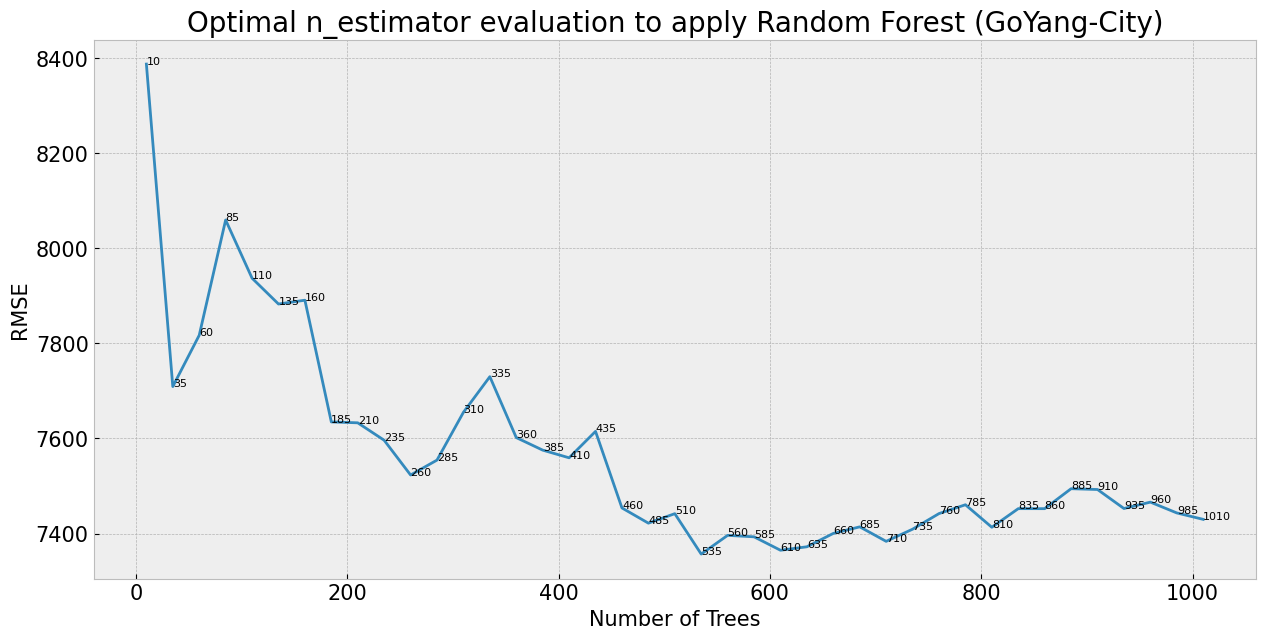

In [39]:
# 0~31까지 반복
for i in range(41):
    
    # n_estimator를 est로 설정
    rf.set_params(n_estimators=est)
    
    # 인구조사 데이터셋으로 훈련
    rf.fit(X_train, y_train)
    
    # RMSE 값을 계산
    rmse = mean_squared_error(y_test, rf.predict(X_test), squared=False)
    
    # rmse와 est를 리스트에 추가함
    rmse_scores.append(rmse)
    estimators.append(est)
    
    # 트리를 25개씩 늘림
    est += 25

# 그래프 크기
plt.figure(figsize=(15,7))

# estimators와 oob_scores를 그래프로 그림
plt.plot(estimators, rmse_scores)

for i in range(len(estimators)):
    plt.annotate(str(estimators[i]), xy=(estimators[i], rmse_scores[i]), fontsize=8)
    
# 축 레이블을 설정
plt.xlabel("Number of Trees", fontsize=15)
plt.ylabel("RMSE", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# 제목을 출력
plt.title(f"Optimal n_estimator evaluation to apply Random Forest ({city_name})", fontsize=20)
plt.grid(True)
plt.savefig(f"./figures/{city_name}_optimal_n_estimator_RF.png", bbox_inches='tight')
plt.show()

#### 2.1.2 교차검증을 통한 모델검증

In [40]:
n_estimator = 50
rf = RandomForestRegressor(n_estimators=n_estimator, warm_start=True, n_jobs=-1, random_state=2)
scores = cross_val_score(rf, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
rmse = np.sqrt(-scores)
print('RMSE:', np.round(rmse,3))
print('RMSE 평균: %0.3f' % (rmse.mean()))

RMSE: [11636.144  7134.396  6994.249  3757.292  4841.735  7331.5    4054.004
  8830.212  5381.181 16971.556]
RMSE 평균: 7693.227


#### 2.1.3 하이퍼파라미터 튜닝

 * 하이퍼파라미터 튜닝을 위한 함수 정의

In [41]:
def randomized_search_reg(params, runs=16, reg=RandomForestRegressor(n_estimators=n_estimator, warm_start=True, random_state=2, n_jobs=-1)):
    rand_reg = RandomizedSearchCV(reg, params, n_iter=runs, scoring='neg_mean_squared_error', cv=10,
                                  n_jobs=-1, random_state=2)
    rand_reg.fit(X_train, y_train)
    best_model = rand_reg.best_estimator_
    best_params = rand_reg.best_params_
    print("최상의 매개변수:", best_params)
    best_score = np.sqrt(-rand_reg.best_score_)
    print("훈련점수: {:.3f}".format(best_score))
    y_pred = best_model.predict(X_test)
    from sklearn.metrics import mean_squared_error as MSE
    rmse_test = mean_squared_error(y_test, y_pred, squared=False)
    print("테스트 세트 점수: {:.3f}".format(rmse_test))
    return best_params

 * 적정 하이퍼파라미터 튜닝을 위한 하이퍼파라미터 값 설정

In [42]:
best_params = randomized_search_reg(
              params={'max_depth':[None, 2, 4, 6, 8, 10, 20],
                      'max_leaf_nodes':[10, 15, 20, 25, 30, 35, 40, 45, 50, None],
                      'max_features':['auto', 0.8, 0.7, 0.6, 0.5, 0.4],
                      'min_impurity_decrease':[0.0, 0.01, 0.05, 0.10, 0.15, 0.2]})

최상의 매개변수: {'min_impurity_decrease': 0.0, 'max_leaf_nodes': 50, 'max_features': 0.7, 'max_depth': 8}
훈련점수: 8459.506
테스트 세트 점수: 7264.196


best_params = randomized_search_reg(
              params={'max_depth':[None, 2, 4, 6, 8, 10, 20],
                      'max_features':['auto', 0.8, 0.7, 0.6, 0.5, 0.4]})

#### 2.1.4 최적 모델적용 및 Test 데이터에 대한 성능평가

In [43]:
# warm_start=True로 RandomForestRegressor 객체를 만듦
rf = RandomForestRegressor(n_estimators=n_estimator, random_state=2, n_jobs=-1, 
                           max_depth=best_params['max_depth'], max_leaf_nodes=best_params['max_leaf_nodes'],
                           max_features=best_params['max_features'], 
                           min_impurity_decrease=best_params['min_impurity_decrease'])

# warm_start=True로 RandomForestRegressor 객체를 만듦
rf = RandomForestRegressor(n_estimators=n_estimator, random_state=2, n_jobs=-1, 
                           max_depth=best_params['max_depth'], 
                           max_features=best_params['max_features'])

In [44]:
rf.fit(X_train, y_train)

# R2과 RMSE 값을 계산
train_rf_r2 = r2_score(y_train, rf.predict(X_train))
train_rf_rmse = mean_squared_error(y_train, rf.predict(X_train), squared=False)
test_rf_r2 = r2_score(y_test, rf.predict(X_test))
test_rf_rmse = mean_squared_error(y_test, rf.predict(X_test), squared=False)

print("RF Train R2: {:.2f}".format(train_rf_r2))
print("RF Train RMSE: {:.2f}".format(train_rf_rmse))
print("RF Test R2: {:.2f}".format(test_rf_r2))
print("RF Test RMSE: {:.2f}".format(test_rf_rmse))

RF Train R2: 0.99
RF Train RMSE: 2046.89
RF Test R2: 0.68
RF Test RMSE: 7264.20


#### 2.1.5 Plotting

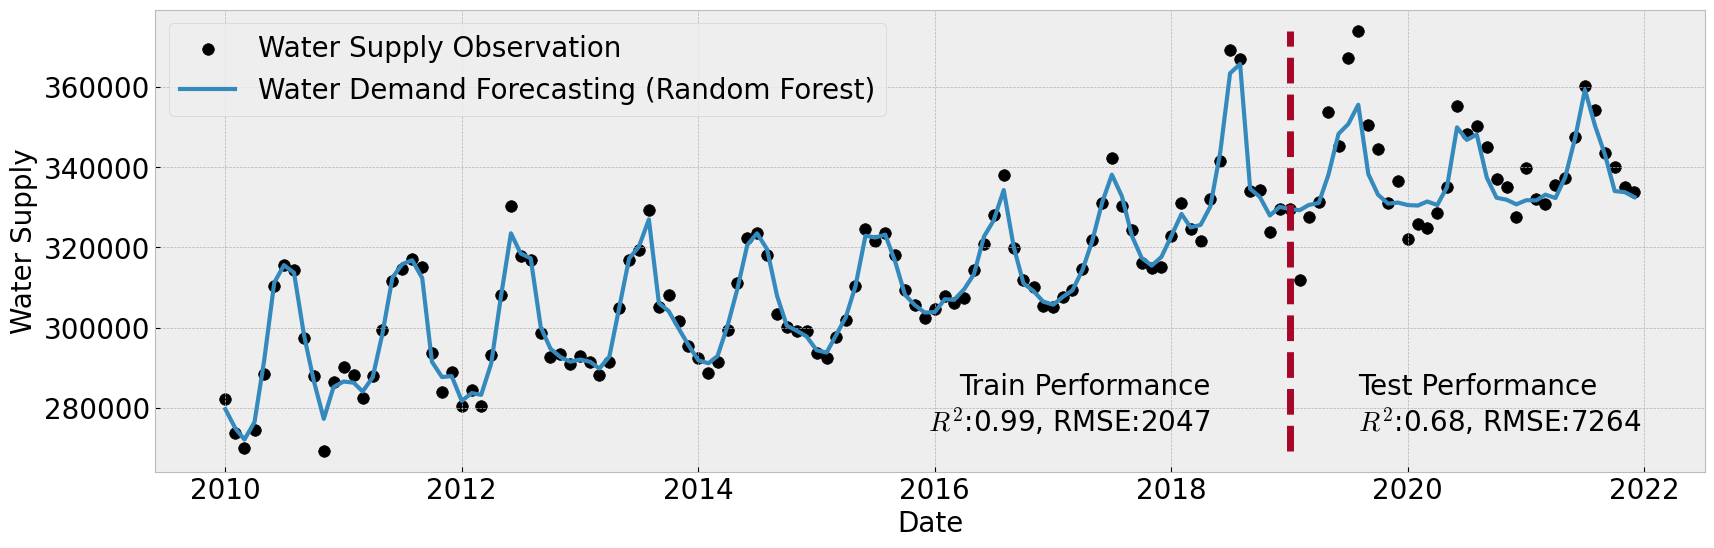

In [45]:
fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(111)

ax.scatter(water_demand["water_supply"].index, water_demand["water_supply"], label='Water Supply Observation', c='black', s=70)  # Plot some data on the axes.
ax.plot(water_demand["water_supply"].index, np.append(rf.predict(X_train), rf.predict(X_test)), linewidth=3, label='Water Demand Forecasting (Random Forest)')  # Plot more data on the axes...
ax.plot([water_demand["water_supply"].index[108], water_demand["water_supply"].index[108]], [water_demand["water_supply"].min(), water_demand["water_supply"].max()], linewidth=5, linestyle="dashed")

ax.text(water_demand["water_supply"].index[100], water_demand["water_supply"].max()-100000, f"Train Performance\n$R^2$:{train_rf_r2:.2f}, RMSE:{train_rf_rmse:.0f}", horizontalalignment='right', size=20)
ax.text(water_demand["water_supply"].index[115], water_demand["water_supply"].max()-100000, f"Test Performance\n$R^2$:{test_rf_r2:.2f}, RMSE:{test_rf_rmse:.0f}", horizontalalignment='left', size=20)

ax.set_xlabel('Date', fontsize=20)  # Add an x-label to the axes.
ax.set_ylabel('Water Supply', fontsize=20)  # Add a y-label to the axes.
#ax.set_title(f"Performance Evaluation using Random Forest with All variables ({city_name})", fontsize=20)  # Add a title to the axes.
ax.legend(fontsize=20)  # Add a legend.
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.grid()
ax.grid()
plt.savefig(f"./figures/{city_name}_performance_plot_rf_all_variable.png", bbox_inches='tight')

In [46]:
water_demand["random_forest"] = np.append(rf.predict(X_train), rf.predict(X_test))
rf_result = water_demand[["water_supply", "random_forest"]]
rf_result.to_csv(f"{city_name}_RF_result_all.csv")

### 2.2 XGBoost

#### 2.2.1 적정 n_estimator 검토

In [47]:
kfold = KFold(n_splits=5, shuffle=True, random_state=2)

def n_estimators(model):
    eval_set = [(X_test, y_test)]
    eval_metric = "rmse"
    model.fit(X_train, y_train, eval_metric=eval_metric,
              eval_set=eval_set, early_stopping_rounds=100)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred)**0.5
    return rmse
    
n_estimators(xgbr(n_estimators=5000))

[0]	validation_0-rmse:248450.71680
[1]	validation_0-rmse:184227.40977
[2]	validation_0-rmse:139158.25050
[3]	validation_0-rmse:103988.17615
[4]	validation_0-rmse:80641.53632
[5]	validation_0-rmse:62980.51663
[6]	validation_0-rmse:47937.39999
[7]	validation_0-rmse:36320.26150
[8]	validation_0-rmse:29445.14104
[9]	validation_0-rmse:25237.03398
[10]	validation_0-rmse:20200.76281
[11]	validation_0-rmse:15472.61011
[12]	validation_0-rmse:13270.80165
[13]	validation_0-rmse:11985.82830
[14]	validation_0-rmse:11713.72995
[15]	validation_0-rmse:11164.12188
[16]	validation_0-rmse:11067.26391
[17]	validation_0-rmse:10763.87721
[18]	validation_0-rmse:10544.46393
[19]	validation_0-rmse:10485.07371
[20]	validation_0-rmse:10338.83018
[21]	validation_0-rmse:10223.62645
[22]	validation_0-rmse:10194.34506
[23]	validation_0-rmse:10107.23254
[24]	validation_0-rmse:10011.52540
[25]	validation_0-rmse:9975.32732
[26]	validation_0-rmse:9978.05691
[27]	validation_0-rmse:9970.06390
[28]	validation_0-rmse:9957.8

9898.173441215771

#### 2.2.2 하이퍼파라미터 튜닝

In [48]:
def grid_search(params, reg=xgbr()):
    grid_reg = GridSearchCV(reg, params, scoring='neg_mean_squared_error', cv=kfold)
    grid_reg.fit(X_train, y_train)
    best_params = grid_reg.best_params_
    print("최상의 매개변수:", best_params)
    best_score = np.sqrt(-grid_reg.best_score_)
    print("최상의 점수:", best_score)
    return best_params
best_params = grid_search(params={'max_depth':[1, 2, 3, 4, 5, 6, 7, 8],
                                  'n_estimators':[1, 3, 10, 20, 30, 40]})

최상의 매개변수: {'max_depth': 1, 'n_estimators': 40}
최상의 점수: 5965.756078792077


#### 2.2.3 최적 모델적용 및 Test 데이터에 대한 성능평가

In [49]:
model = xgbr(max_depth=best_params['max_depth'],
             n_estimators=best_params['n_estimators'])
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=1, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=40, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [50]:
# R2과 RMSE 값을 계산
train_xgb_r2 = r2_score(y_train, model.predict(X_train))
train_xgb_rmse = mean_squared_error(y_train, model.predict(X_train), squared=False)
test_xgb_r2 = r2_score(y_test, model.predict(X_test))
test_xgb_rmse = mean_squared_error(y_test, model.predict(X_test), squared=False)

print("XGB Train R2: {:.2f}".format(train_xgb_r2))
print("XGB Train RMSE: {:.2f}".format(train_xgb_rmse))
print("XGB Test R2: {:.2f}".format(test_xgb_r2))
print("XGB Test RMSE: {:.2f}".format(test_xgb_rmse))

XGB Train R2: 0.96
XGB Train RMSE: 3603.06
XGB Test R2: 0.56
XGB Test RMSE: 8532.56


#### 2.2.4 Plotting

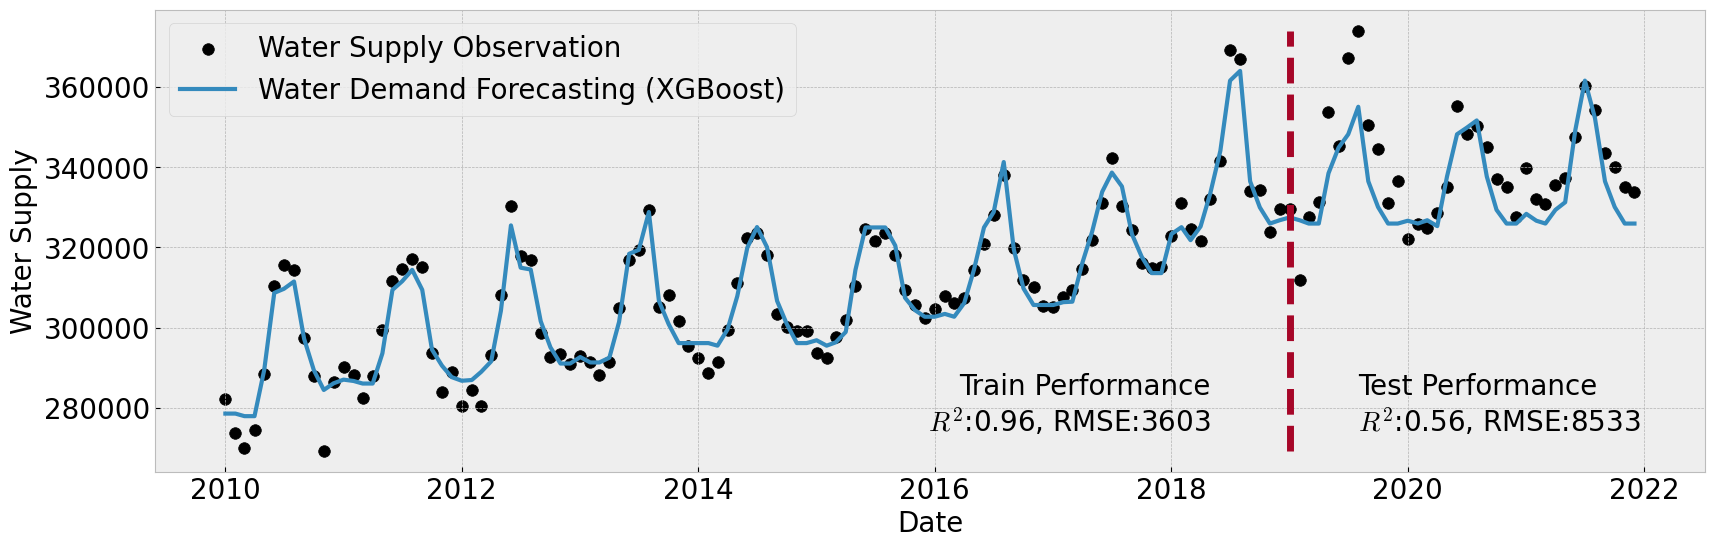

In [51]:
fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(111)

#ax.plot(water_demand["water_supply"].index, water_demand["water_supply"], linewidth=3, label='Water Supply Observation')  # Plot some data on the axes.
#ax.scatter(water_demand["water_supply"].index, np.append(model.predict(X_train), model.predict(X_test)), c='r', s=70, label='Water Demand Forecasting (XGBoost)')  # Plot more data on the axes...

ax.scatter(water_demand["water_supply"].index, water_demand["water_supply"], label='Water Supply Observation', c='black', s=70)  # Plot some data on the axes.
ax.plot(water_demand["water_supply"].index, np.append(model.predict(X_train), model.predict(X_test)), linewidth=3, label='Water Demand Forecasting (XGBoost)')  # Plot more data on the axes...

ax.plot([water_demand["water_supply"].index[108], water_demand["water_supply"].index[108]], [water_demand["water_supply"].min(), water_demand["water_supply"].max()], linewidth=5, linestyle="dashed")
#ax.text(water_demand["water_supply"].index[90], water_demand["water_supply"].max()-10000, "Train", horizontalalignment='left', size=20)
#ax.text(water_demand["water_supply"].index[125], water_demand["water_supply"].max()-10000, "Test", horizontalalignment='right', size=20)
ax.text(water_demand["water_supply"].index[100], water_demand["water_supply"].max()-100000, f"Train Performance\n$R^2$:{train_xgb_r2:.2f}, RMSE:{train_xgb_rmse:.0f}", horizontalalignment='right', size=20)
ax.text(water_demand["water_supply"].index[115], water_demand["water_supply"].max()-100000, f"Test Performance\n$R^2$:{test_xgb_r2:.2f}, RMSE:{test_xgb_rmse:.0f}", horizontalalignment='left', size=20)

ax.set_xlabel('Date', fontsize=20)  # Add an x-label to the axes.
ax.set_ylabel('Water Supply', fontsize=20)  # Add a y-label to the axes.
#ax.set_title(f"Performance Evaluation using Random Forest with All variables ({city_name})", fontsize=20)  # Add a title to the axes.
ax.legend(fontsize=20)  # Add a legend.
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.grid()
ax.grid()
plt.savefig(f"./figures/{city_name}_performance_plot_xgb_all_variable.png", bbox_inches='tight')

In [52]:
water_demand["xgboost"] = np.append(model.predict(X_train), model.predict(X_test))
rf_result = water_demand[["water_supply", "xgboost"]]
rf_result.to_csv(f"{city_name}_XGBoost_result_all.csv")